In [63]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
#load the basic libraries
plt.style.use('default')
import tensorflow as tf
#load libraries for data preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
#load libraries for building CNN
from tensorflow.keras.layers import *
from tensorflow.keras import layers , models, optimizers
from tensorflow.keras.models import Sequential, Model
#load libraries for ResNet transfer learning
from tensorflow.keras.applications import ResNet50V2
#load libraries for callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#load libraries for visualizing
from tensorflow.keras.utils import plot_model
#load libraries for data preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
#load libraries for building CNN
from tensorflow.keras.layers import *
from tensorflow.keras import layers , models, optimizers
from tensorflow.keras.models import Sequential, Model
#load libraries for ResNet transfer learning
from tensorflow.keras.applications import ResNet50V2
#load libraries for callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#load libraries for visualizing
from tensorflow.keras.utils import plot_model

In [64]:
print(os.listdir("C:/Users/tahir_02svck/UK project/archive (2)"))

['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']


In [65]:
data_path = 'C:/Users/tahir_02svck/UK project/archive (2)'
data_dir_list = os.listdir(data_path)

num_epoch=10

img_data_list=[]


for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(48,48))
        img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

Loaded the images of dataset-anger

Loaded the images of dataset-contempt

Loaded the images of dataset-disgust

Loaded the images of dataset-fear

Loaded the images of dataset-happy

Loaded the images of dataset-sadness

Loaded the images of dataset-surprise



(967, 48, 48, 3)

In [90]:
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:134]=0 #135
labels[135:188]=1 #54
labels[189:365]=2 #177
labels[366:440]=3 #75
labels[441:647]=4 #207
labels[648:731]=5 #84
labels[732:980]=6 #249

names = ['anger','contempt','disgust','fear','happy','sadness','surprise']

def getLabel(id):
    return ['anger','contempt','disgust','fear','happy','sadness','surprise'][id]

In [92]:
from tensorflow.keras.utils import to_categorical

Y = to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)
x_test=X_test
y_test

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [139]:
def create_model():
    input_shape=(48,48,3)

    model = Sequential()
    model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='RMSprop')
    
    return model

In [140]:
model_custom = create_model()
model_custom.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_132 (Conv2D)         (None, 48, 48, 6)         456       
                                                                 
 max_pooling2d_120 (MaxPooli  (None, 24, 24, 6)        0         
 ng2D)                                                           
                                                                 
 conv2d_133 (Conv2D)         (None, 24, 24, 16)        2416      
                                                                 
 activation_15 (Activation)  (None, 24, 24, 16)        0         
                                                                 
 max_pooling2d_121 (MaxPooli  (None, 12, 12, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_134 (Conv2D)         (None, 10, 10, 64)      

In [141]:
from sklearn.model_selection import KFold

In [142]:
kf = KFold(n_splits=5, shuffle=False)

In [143]:
from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [144]:
BS = 16
EPOCHS = 100

In [145]:
result = []
scores_loss = []
scores_acc = []
k_no = 0
for train_index, test_index in kf.split(x):
    X_Train_ = x[train_index]
    Y_Train = y[train_index]
    X_Test_ = x[test_index]
    Y_Test = y[test_index]

    file_path = "best_weights_best_"+str(k_no)+".hdf5"
    checkpoint = ModelCheckpoint(file_path, monitor='loss', verbose=0, save_best_only=True, mode='min')
    early = EarlyStopping(monitor="loss", mode="min", patience=8)

    callbacks_list = [checkpoint, early]

    model = create_model()
    hist = model.fit_generator(aug.flow(X_Train_, Y_Train), epochs=EPOCHS,validation_data=(X_Test_, Y_Test), callbacks=callbacks_list, verbose=1)
    # model.fit(X_Train, Y_Train, batch_size=batch_size, epochs=epochs, validation_data=(X_Test, Y_Test), verbose=1)
    model.load_weights(file_path)
    result.append(model.predict(X_Test_))
    score = model.evaluate(X_Test_,Y_Test, verbose=1)
    scores_loss.append(score[0])
    scores_acc.append(score[1])
    k_no+=1
    # After the loop
max_acc_index = np.argmax(scores_acc)
min_loss_index = np.argmin(scores_loss)

# Get the corresponding results and scores
best_acc_result = result[max_acc_index]
best_acc_score = scores_acc[max_acc_index]
best_acc_loss = scores_loss[max_acc_index]

best_loss_result = result[min_loss_index]
best_loss_score = scores_acc[min_loss_index]
best_loss_loss = scores_loss[min_loss_index]

# Print or use the best accuracy results
print(f"Best Accuracy (Fold {max_acc_index + 1}):")
print(f"Accuracy: {best_acc_score}")
print(f"Loss: {best_acc_loss}")

# Print or use the best loss results
print(f"\nBest Loss (Fold {min_loss_index + 1}):")
print(f"Accuracy: {best_loss_score}")
print(f"Loss: {best_loss_loss}")


Epoch 1/100


C:\Users\tahir_02svck\AppData\Local\Temp\ipykernel_22224\970952525.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(aug.flow(X_Train_, Y_Train), epochs=EPOCHS,validation_data=(X_Test_, Y_Test), callbacks=callbacks_list, verbose=1)


25/25 [==============================] - 4s 99ms/step - loss: 1.8538 - accuracy: 0.2303 - val_loss: 1.8658 - val_accuracy: 0.2371
Epoch 2/100
25/25 [==============================] - 3s 107ms/step - loss: 1.8355 - accuracy: 0.2354 - val_loss: 1.8143 - val_accuracy: 0.4072
Epoch 3/100
25/25 [==============================] - 4s 145ms/step - loss: 1.8252 - accuracy: 0.2730 - val_loss: 1.7780 - val_accuracy: 0.4278
Epoch 4/100
25/25 [==============================] - 4s 154ms/step - loss: 1.7379 - accuracy: 0.3415 - val_loss: 1.6007 - val_accuracy: 0.4381
Epoch 5/100
25/25 [==============================] - 4s 146ms/step - loss: 1.5678 - accuracy: 0.4398 - val_loss: 1.3987 - val_accuracy: 0.5206
Epoch 6/100
25/25 [==============================] - 3s 134ms/step - loss: 1.4395 - accuracy: 0.4567 - val_loss: 1.4007 - val_accuracy: 0.4845
Epoch 7/100
25/25 [==============================] - 4s 145ms/step - loss: 1.4064 - accuracy: 0.4903 - val_loss: 1.2259 - val_accuracy: 0.5825
Epoch 8/100


25/25 [==============================] - 4s 137ms/step - loss: 0.5815 - accuracy: 0.7969 - val_loss: 0.4371 - val_accuracy: 0.8351
Epoch 59/100
25/25 [==============================] - 4s 159ms/step - loss: 0.5516 - accuracy: 0.8163 - val_loss: 0.3757 - val_accuracy: 0.8814
Epoch 60/100
25/25 [==============================] - 4s 175ms/step - loss: 0.5563 - accuracy: 0.8021 - val_loss: 0.4222 - val_accuracy: 0.8402
Epoch 61/100
25/25 [==============================] - 4s 150ms/step - loss: 0.5654 - accuracy: 0.7982 - val_loss: 0.7673 - val_accuracy: 0.6856
Epoch 62/100
25/25 [==============================] - 4s 157ms/step - loss: 0.5365 - accuracy: 0.8137 - val_loss: 0.3770 - val_accuracy: 0.8866
Epoch 63/100
25/25 [==============================] - 4s 167ms/step - loss: 0.5321 - accuracy: 0.8124 - val_loss: 0.3760 - val_accuracy: 0.8814
Epoch 64/100
25/25 [==============================] - 4s 169ms/step - loss: 0.5481 - accuracy: 0.8060 - val_loss: 0.5245 - val_accuracy: 0.7990
Epoch

25/25 [==============================] - 4s 152ms/step - loss: 0.8317 - accuracy: 0.7167 - val_loss: 0.6620 - val_accuracy: 0.7835
Epoch 33/100
25/25 [==============================] - 4s 149ms/step - loss: 0.8038 - accuracy: 0.7180 - val_loss: 0.5871 - val_accuracy: 0.7732
Epoch 34/100
25/25 [==============================] - 4s 144ms/step - loss: 0.7713 - accuracy: 0.7464 - val_loss: 0.6026 - val_accuracy: 0.7938
Epoch 35/100
25/25 [==============================] - 4s 147ms/step - loss: 0.7720 - accuracy: 0.7439 - val_loss: 0.5753 - val_accuracy: 0.7887
Epoch 36/100
25/25 [==============================] - 3s 137ms/step - loss: 0.7931 - accuracy: 0.7128 - val_loss: 0.5842 - val_accuracy: 0.8093
Epoch 37/100
25/25 [==============================] - 4s 148ms/step - loss: 0.7760 - accuracy: 0.7296 - val_loss: 0.6414 - val_accuracy: 0.7938
Epoch 38/100
25/25 [==============================] - 4s 149ms/step - loss: 0.7214 - accuracy: 0.7374 - val_loss: 0.5525 - val_accuracy: 0.7990
Epoch

Epoch 89/100
25/25 [==============================] - 4s 141ms/step - loss: 0.4131 - accuracy: 0.8590 - val_loss: 0.3872 - val_accuracy: 0.8866
Epoch 90/100
25/25 [==============================] - 4s 148ms/step - loss: 0.4425 - accuracy: 0.8525 - val_loss: 0.3490 - val_accuracy: 0.8763
Epoch 91/100
25/25 [==============================] - 4s 143ms/step - loss: 0.4118 - accuracy: 0.8590 - val_loss: 0.3231 - val_accuracy: 0.9021
Epoch 92/100
25/25 [==============================] - 4s 139ms/step - loss: 0.4446 - accuracy: 0.8292 - val_loss: 0.3540 - val_accuracy: 0.8969
Epoch 93/100
25/25 [==============================] - 4s 142ms/step - loss: 0.3933 - accuracy: 0.8642 - val_loss: 0.3707 - val_accuracy: 0.9124
Epoch 94/100
25/25 [==============================] - 3s 138ms/step - loss: 0.4362 - accuracy: 0.8473 - val_loss: 0.3934 - val_accuracy: 0.8814
Epoch 95/100
25/25 [==============================] - 4s 145ms/step - loss: 0.4421 - accuracy: 0.8499 - val_loss: 0.3439 - val_accuracy:

25/25 [==============================] - 4s 141ms/step - loss: 0.6245 - accuracy: 0.7623 - val_loss: 0.5538 - val_accuracy: 0.8394
Epoch 46/100
25/25 [==============================] - 3s 136ms/step - loss: 0.6607 - accuracy: 0.7403 - val_loss: 0.5577 - val_accuracy: 0.8238
Epoch 47/100
25/25 [==============================] - 4s 151ms/step - loss: 0.6268 - accuracy: 0.7959 - val_loss: 0.5794 - val_accuracy: 0.8342
Epoch 48/100
25/25 [==============================] - 4s 148ms/step - loss: 0.6420 - accuracy: 0.7597 - val_loss: 0.5521 - val_accuracy: 0.8290
Epoch 49/100
25/25 [==============================] - 4s 145ms/step - loss: 0.5735 - accuracy: 0.7881 - val_loss: 0.6162 - val_accuracy: 0.8135
Epoch 50/100
25/25 [==============================] - 3s 139ms/step - loss: 0.6335 - accuracy: 0.7610 - val_loss: 0.6825 - val_accuracy: 0.7720
Epoch 51/100
25/25 [==============================] - 4s 143ms/step - loss: 0.6192 - accuracy: 0.7817 - val_loss: 0.5496 - val_accuracy: 0.8497
Epoch

25/25 [==============================] - 4s 99ms/step - loss: 1.8627 - accuracy: 0.2222 - val_loss: 1.8368 - val_accuracy: 0.2280
Epoch 2/100
25/25 [==============================] - 2s 94ms/step - loss: 1.8175 - accuracy: 0.2700 - val_loss: 1.7180 - val_accuracy: 0.3990
Epoch 3/100
25/25 [==============================] - 3s 133ms/step - loss: 1.6923 - accuracy: 0.3850 - val_loss: 1.4689 - val_accuracy: 0.4041
Epoch 4/100
25/25 [==============================] - 4s 149ms/step - loss: 1.5742 - accuracy: 0.4109 - val_loss: 1.3611 - val_accuracy: 0.4922
Epoch 5/100
25/25 [==============================] - 4s 139ms/step - loss: 1.4625 - accuracy: 0.4522 - val_loss: 1.2565 - val_accuracy: 0.5285
Epoch 6/100
25/25 [==============================] - 3s 112ms/step - loss: 1.4108 - accuracy: 0.4625 - val_loss: 1.2119 - val_accuracy: 0.5440
Epoch 7/100
25/25 [==============================] - 3s 129ms/step - loss: 1.3575 - accuracy: 0.5129 - val_loss: 1.2070 - val_accuracy: 0.5648
Epoch 8/100
2

25/25 [==============================] - 3s 130ms/step - loss: 0.5852 - accuracy: 0.7894 - val_loss: 0.3538 - val_accuracy: 0.8912
Epoch 59/100
25/25 [==============================] - 2s 81ms/step - loss: 0.5715 - accuracy: 0.7984 - val_loss: 0.3841 - val_accuracy: 0.8808
Epoch 60/100
25/25 [==============================] - 3s 106ms/step - loss: 0.5453 - accuracy: 0.7984 - val_loss: 0.3621 - val_accuracy: 0.8705
Epoch 61/100
25/25 [==============================] - 3s 117ms/step - loss: 0.5392 - accuracy: 0.8152 - val_loss: 0.4012 - val_accuracy: 0.8446
Epoch 62/100
25/25 [==============================] - 3s 113ms/step - loss: 0.5586 - accuracy: 0.8295 - val_loss: 0.3553 - val_accuracy: 0.8964
Epoch 63/100
25/25 [==============================] - 3s 134ms/step - loss: 0.5456 - accuracy: 0.8036 - val_loss: 0.3680 - val_accuracy: 0.8860
Epoch 64/100
25/25 [==============================] - 3s 127ms/step - loss: 0.5677 - accuracy: 0.8088 - val_loss: 0.3250 - val_accuracy: 0.8912
Epoch 

25/25 [==============================] - 2s 84ms/step - loss: 1.2257 - accuracy: 0.5116 - val_loss: 0.8632 - val_accuracy: 0.7306
Epoch 15/100
25/25 [==============================] - 3s 115ms/step - loss: 1.1903 - accuracy: 0.5581 - val_loss: 0.8481 - val_accuracy: 0.7358
Epoch 16/100
25/25 [==============================] - 3s 131ms/step - loss: 1.1600 - accuracy: 0.5711 - val_loss: 0.8543 - val_accuracy: 0.6736
Epoch 17/100
25/25 [==============================] - 3s 138ms/step - loss: 1.1305 - accuracy: 0.5827 - val_loss: 0.8125 - val_accuracy: 0.6891
Epoch 18/100
25/25 [==============================] - 3s 131ms/step - loss: 1.1104 - accuracy: 0.5866 - val_loss: 0.8571 - val_accuracy: 0.6684
Epoch 19/100
25/25 [==============================] - 3s 132ms/step - loss: 1.0849 - accuracy: 0.6137 - val_loss: 0.7182 - val_accuracy: 0.7824
Epoch 20/100
25/25 [==============================] - 3s 119ms/step - loss: 1.0656 - accuracy: 0.6382 - val_loss: 0.7218 - val_accuracy: 0.7513
Epoch 

In [61]:
from tensorflow.keras.models import load_model

loaded_model = load_model("best_weights_best_4.hdf5")

In [146]:
print(scores_acc,scores_loss)

[0.876288652420044, 0.9278350472450256, 0.8963730335235596, 0.9067357778549194, 0.8497409224510193] [0.38836950063705444, 0.31569844484329224, 0.4433015286922455, 0.2762000858783722, 0.5737554430961609]


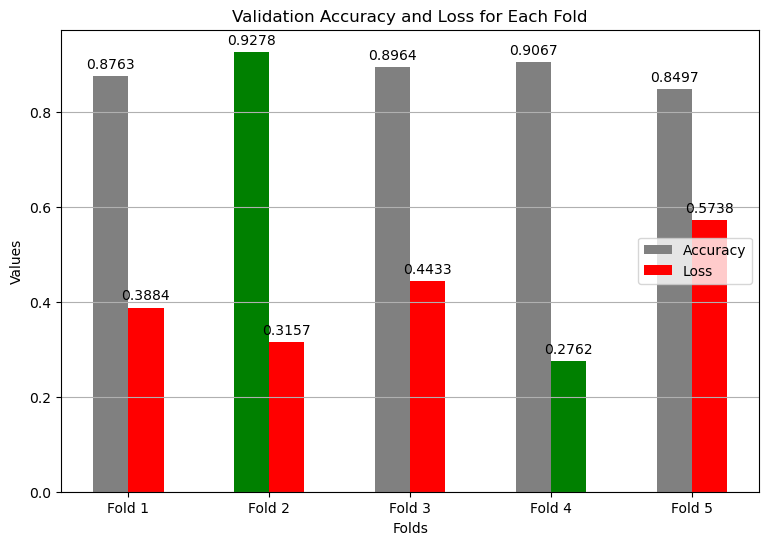

In [221]:
import matplotlib.pyplot as plt
import numpy as np

# Data for visualization
fold_labels = [f"Fold {i + 1}" for i in range(len(scores_acc))]
accuracy_values = scores_acc
loss_values = scores_loss

# Find the index of the best accuracy and best loss
best_acc_fold_index = np.argmax(scores_acc)
best_loss_fold_index = np.argmin(scores_loss)

# Grouped bar plot for accuracy and loss
bar_width = 0.25
index = np.arange(len(fold_labels))

fig, ax = plt.subplots(figsize=(9, 6))
bar1 = ax.bar(index, accuracy_values, bar_width, color=['green' if i == best_acc_fold_index else 'gray' for i in range(len(fold_labels))], label='Accuracy')
bar2 = ax.bar(index + bar_width, loss_values, bar_width, color=['green' if i == best_loss_fold_index else 'red' for i in range(len(fold_labels))], label='Loss')

# Annotate values on each bar
for i, v in enumerate(accuracy_values):
    ax.text(i, v + 0.01, f'{v:.4f}', color='black', ha='center', va='bottom')

for i, v in enumerate(loss_values):
    ax.text(i + bar_width, v + 0.01, f'{v:.4f}', color='black', ha='center', va='bottom')

ax.set_xlabel('Folds')
ax.set_ylabel('Values')
ax.set_title('Validation Accuracy and Loss for Each Fold')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(fold_labels)
ax.legend(loc='center right')  # Adjust legend placement
ax.grid(axis='y')
plt.savefig('Each_Fold_performance.png', dpi=1200)

plt.show()


In [147]:
value_min = min(scores_loss)
value_index = scores_loss.index(value_min)
print(value_index)

3


In [177]:
model.load_weights("best_weights_best_"+str(value_index)+".hdf5")

In [178]:
best_model = model

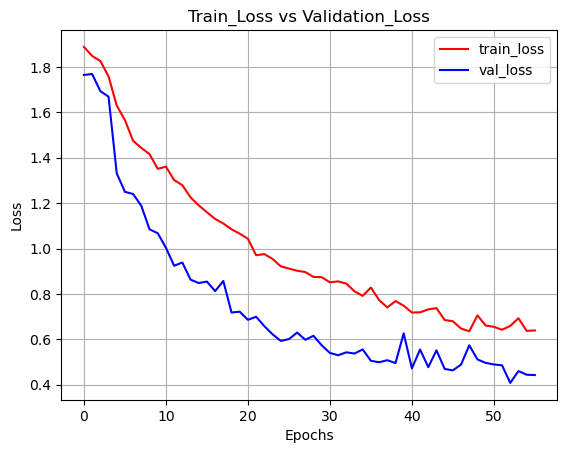

In [190]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('Train_Loss vs Validation_Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

# Save the figure with DPI set to 1200
plt.savefig('Loss_plot.png', dpi=1200)

# Show the plot if needed
plt.show()


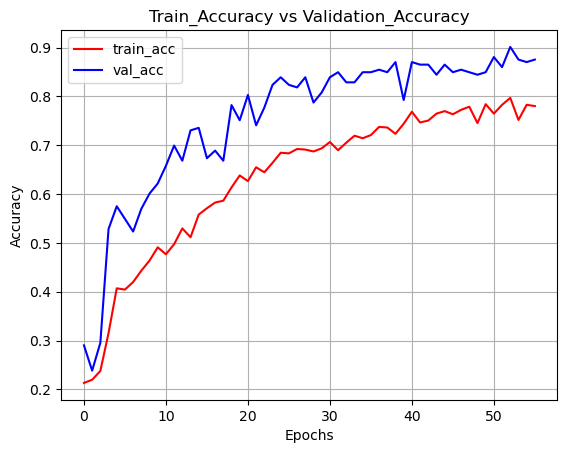

In [189]:
import matplotlib.pyplot as plt

# Your code for plotting
plt.plot(epochs, train_acc, 'r', label='train_acc')
plt.plot(epochs, val_acc, 'b', label='val_acc')
plt.title('Train_Accuracy vs Validation_Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

# Save the figure with DPI set to 1200
plt.savefig('accuracy_plot.png', dpi=1200)

# Show the plot if needed
plt.show()

In [161]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.datasets import make_classification
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [162]:
from sklearn.metrics import confusion_matrix

In [163]:
import numpy as np
# Evaluate on test set
score = best_model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])


Test Loss: 0.17003773152828217
Test accuracy: 0.9278350472450256


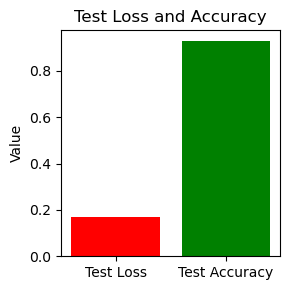

In [164]:
import matplotlib.pyplot as plt

# Evaluate on the test set
score = best_model.evaluate(X_test, y_test, verbose=0)
test_loss = score[0]
test_accuracy = score[1]

# Plotting the results using a bar graph
fig, axes = plt.subplots(figsize=(3, 3))

# Bar graph for test loss and accuracy
axes.bar(['Test Loss', 'Test Accuracy'], [test_loss, test_accuracy], color=['red', 'green'])
axes.set_title('Test Loss and Accuracy')
axes.set_ylabel('Value')
plt.savefig('test_loss1_accuracy.png', dpi=1200, bbox_inches='tight')

plt.tight_layout()
plt.show()


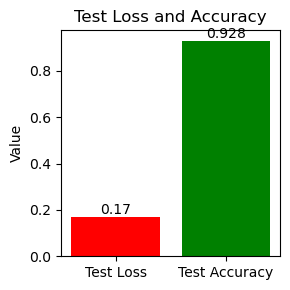

In [165]:
import matplotlib.pyplot as plt

# Evaluate on the test set
score = best_model.evaluate(X_test, y_test, verbose=0)
test_loss = score[0]
test_accuracy = score[1]

# Plotting the results using a bar graph
fig, axes = plt.subplots(figsize=(3, 3))

# Bar graph for test loss and accuracy
bars = axes.bar(['Test Loss', 'Test Accuracy'], [test_loss, test_accuracy], color=['red', 'green'])
axes.set_title('Test Loss and Accuracy')
axes.set_ylabel('Value')

# Display the values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

plt.tight_layout()

# Save the figure with DPI 1200
plt.savefig('test_loss_accuracy.png', dpi=1200, bbox_inches='tight')

plt.show()


In [169]:
#Model Save
best_model.save_weights('model_weights.h5')
best_model.save('model_keras.h5')

In [170]:
from sklearn.metrics import confusion_matrix

# Predict classes for the test set
y_pred_probs = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Create confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Normalize confusion matrix if needed
# cm = cm.astype(np.float) / cm.sum(axis=1)[:, np.newaxis]

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)


7/7 [==============================] - 0s 17ms/step
Confusion Matrix:
[[26  1  0  0  0  5  0]
 [ 0 10  0  1  0  0  0]
 [ 0  1 32  1  0  0  0]
 [ 0  0  0 15  2  0  0]
 [ 0  0  0  0 36  1  0]
 [ 0  2  0  0  0 13  0]
 [ 0  0  0  0  0  0 48]]


In [163]:
# from sklearn.metrics import confusion_matrix
# results = best_model.predict_classes(X_test)
# cm = confusion_matrix(np.where(y_test == 1)[1], results)
#cm = cm.astype(np.float) / cm.sum(axis=1)[:, np.newaxis]

In [171]:
import seaborn as sns
import pandas as pd

In [172]:
label_mapdisgust = ['Anger','Contempt','Disgust','Fear','Happy','Sadness','Surprise']

In [173]:
#Transform to df for easier plotting
cm_df = pd.DataFrame(cm, index = label_mapdisgust,
                     columns = label_mapdisgust
                    )

In [174]:
final_cm = cm_df

In [175]:
final_cm

,Anger,Contempt,Disgust,Fear,Happy,Sadness,Surprise
Anger,26,1,0,0,0,5,0
Contempt,0,10,0,1,0,0,0
Disgust,0,1,32,1,0,0,0
Fear,0,0,0,15,2,0,0
Happy,0,0,0,0,36,1,0
Sadness,0,2,0,0,0,13,0
Surprise,0,0,0,0,0,0,48


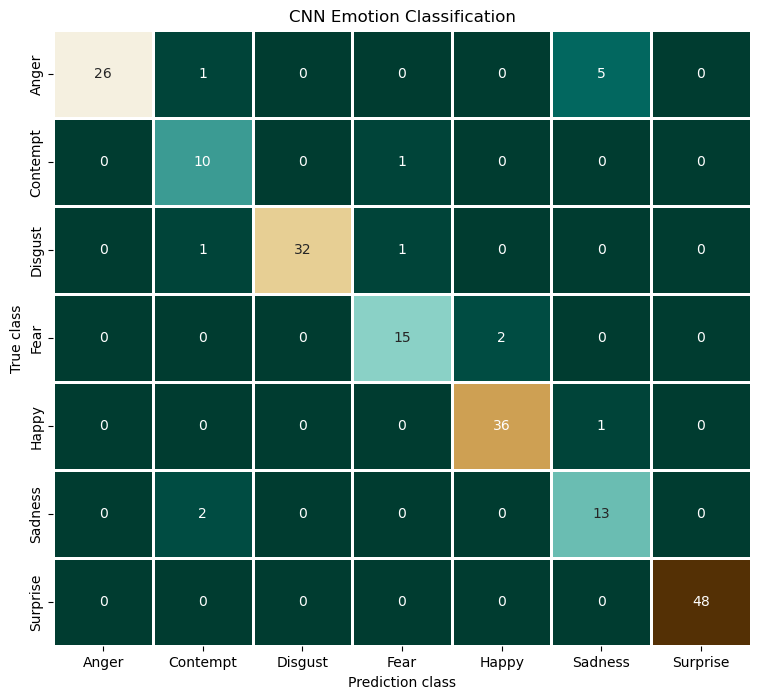

In [226]:
plt.figure(figsize = (9,8))
sns.heatmap(final_cm, annot = True,cmap='BrBG_r',cbar=False,linewidth=2,fmt='d')
plt.title('CNN Emotion Classification')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.savefig('confusion_metrics.png', dpi=1200)

plt.show()

In [179]:
from sklearn.metrics import roc_curve,auc
from itertools import cycle
#predict
y_pred = best_model.predict(X_test)

7/7 [==============================] - 0s 16ms/step


In [180]:
new_label = ['Anger','Contempt','Disgust','Fear','Happy','Sadness','Surprise']
final_label = new_label
new_class = 7

In [181]:
#ravel flatten the array into single vector
y_pred_ravel = y_pred.ravel()
lw = 2

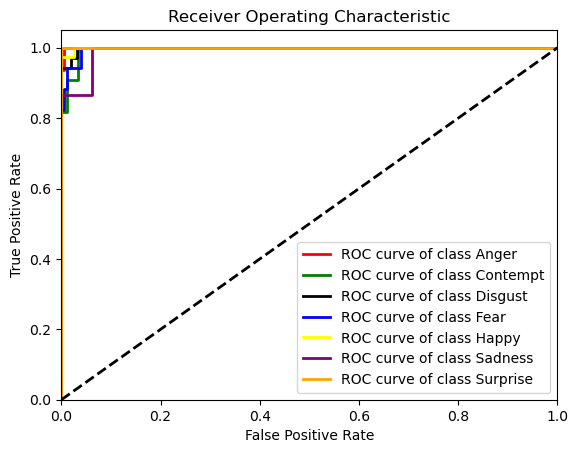

In [192]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(new_class):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#colors = cycle(['red', 'green','black'])
colors = cycle(['red', 'green','black','blue', 'yellow','purple','orange'])
for i, color in zip(range(new_class), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0}'''.format(final_label[i]))
    

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Roc_curve.png', dpi=1200)

plt.show()

7/7 [==============================] - 0s 15ms/step


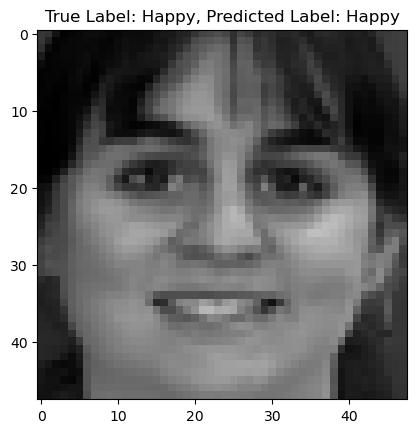

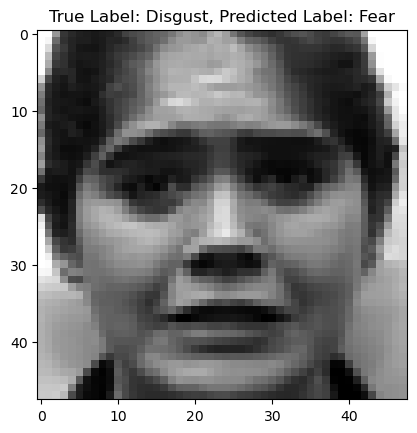

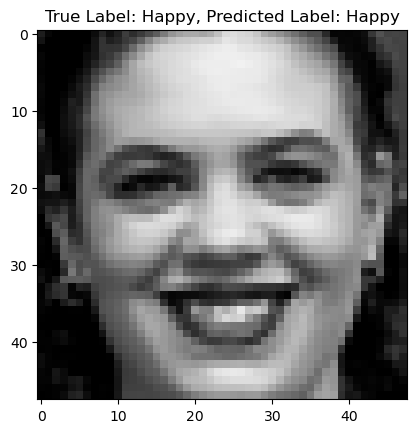

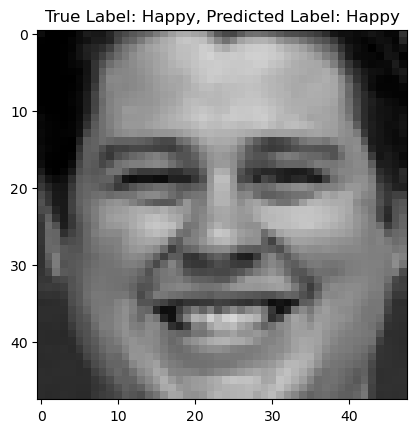

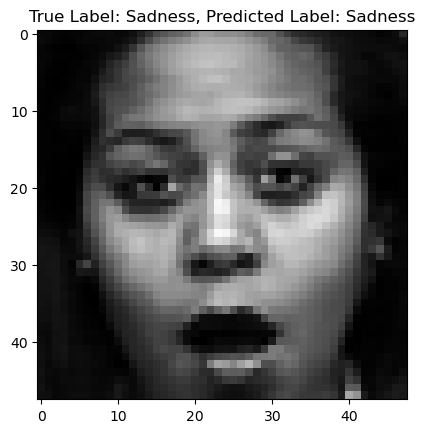

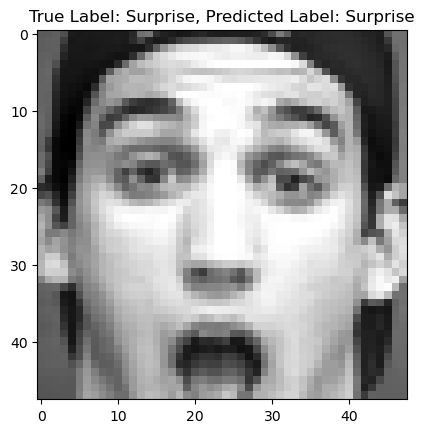

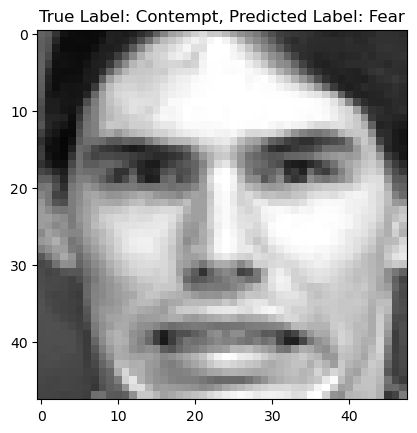

In [183]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_test contains your images and y_test contains true labels
label_names = ['Anger','Contempt','Disgust','Fear','Happy','Sadness','Surprise']

# Get model predictions for the test set
y_pred_probs = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Randomly select some images for visualization
num_images_to_visualize = 7
selected_indices = np.random.choice(len(X_test), num_images_to_visualize, replace=False)

# Visualize the selected images along with true and predicted labels
for idx in selected_indices:
    plt.imshow(X_test[idx])
    true_label = label_names[np.argmax(y_test[idx])]
    pred_label = label_names[y_pred_classes[idx]]
    plt.title(f'True Label: {true_label}, Predicted Label: {pred_label}')
    plt.show()


7/7 [==============================] - 0s 15ms/step


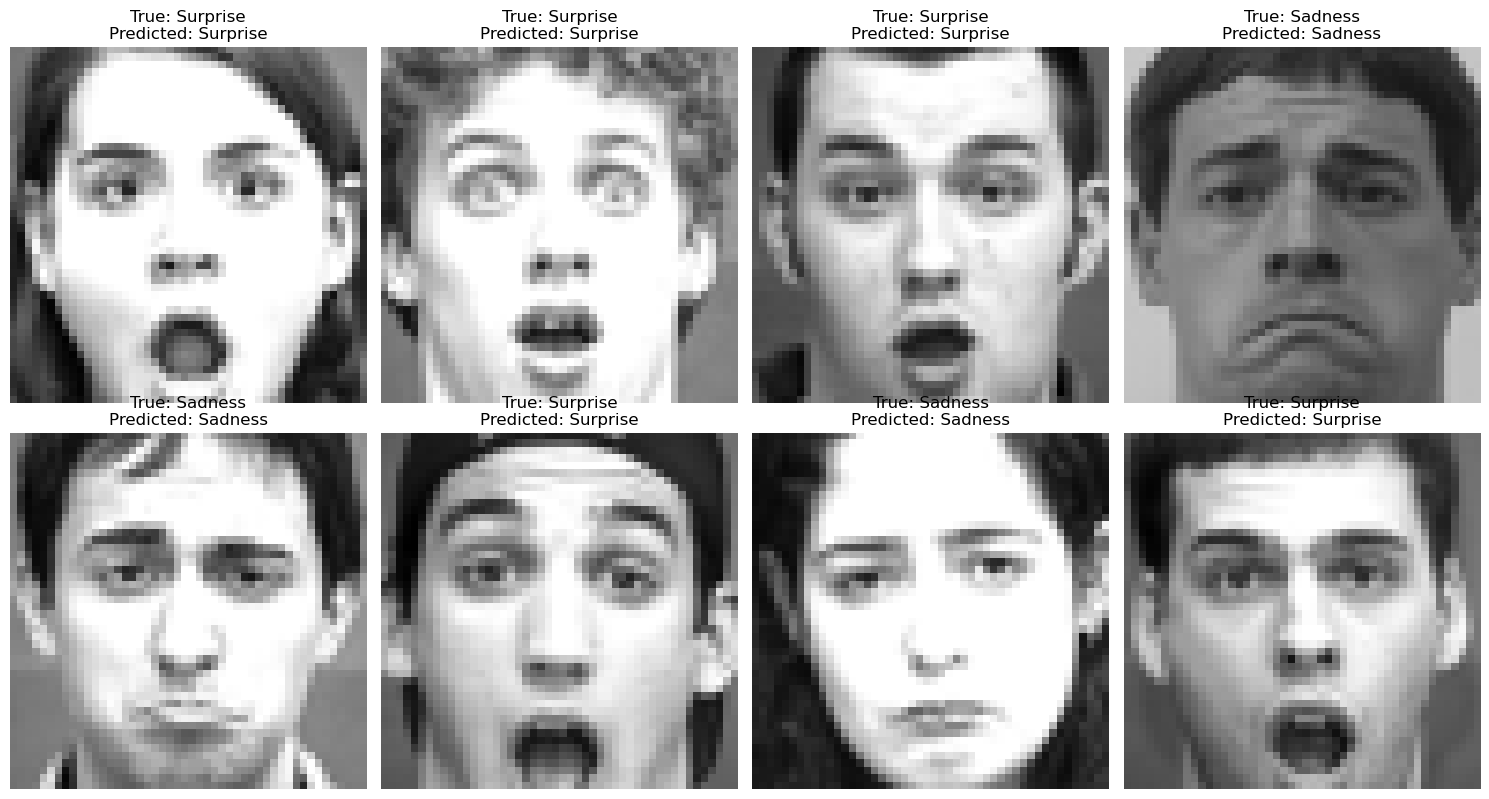

In [184]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_test contains your images and y_test contains true labels
label_names = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Sadness', 'Surprise']

# Get model predictions for the test set
y_pred_probs = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Define the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 4  # You can adjust this based on your preference

# Set up the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

# Visualize test images along with true and predicted labels
for i in range(num_rows):
    for j in range(num_cols):
        idx = i * num_cols + j
        axes[i, j].imshow(X_test[idx])
        true_label = label_names[np.argmax(y_test[idx])]
        pred_label = label_names[y_pred_classes[idx]]
        axes[i, j].set_title(f'True: {true_label}\nPredicted: {pred_label}')
        axes[i, j].axis('off')  # Turn off axis ticks and labels

plt.tight_layout()
plt.show()


7/7 [==============================] - 0s 15ms/step


IndexError: index 2 is out of bounds for axis 0 with size 2

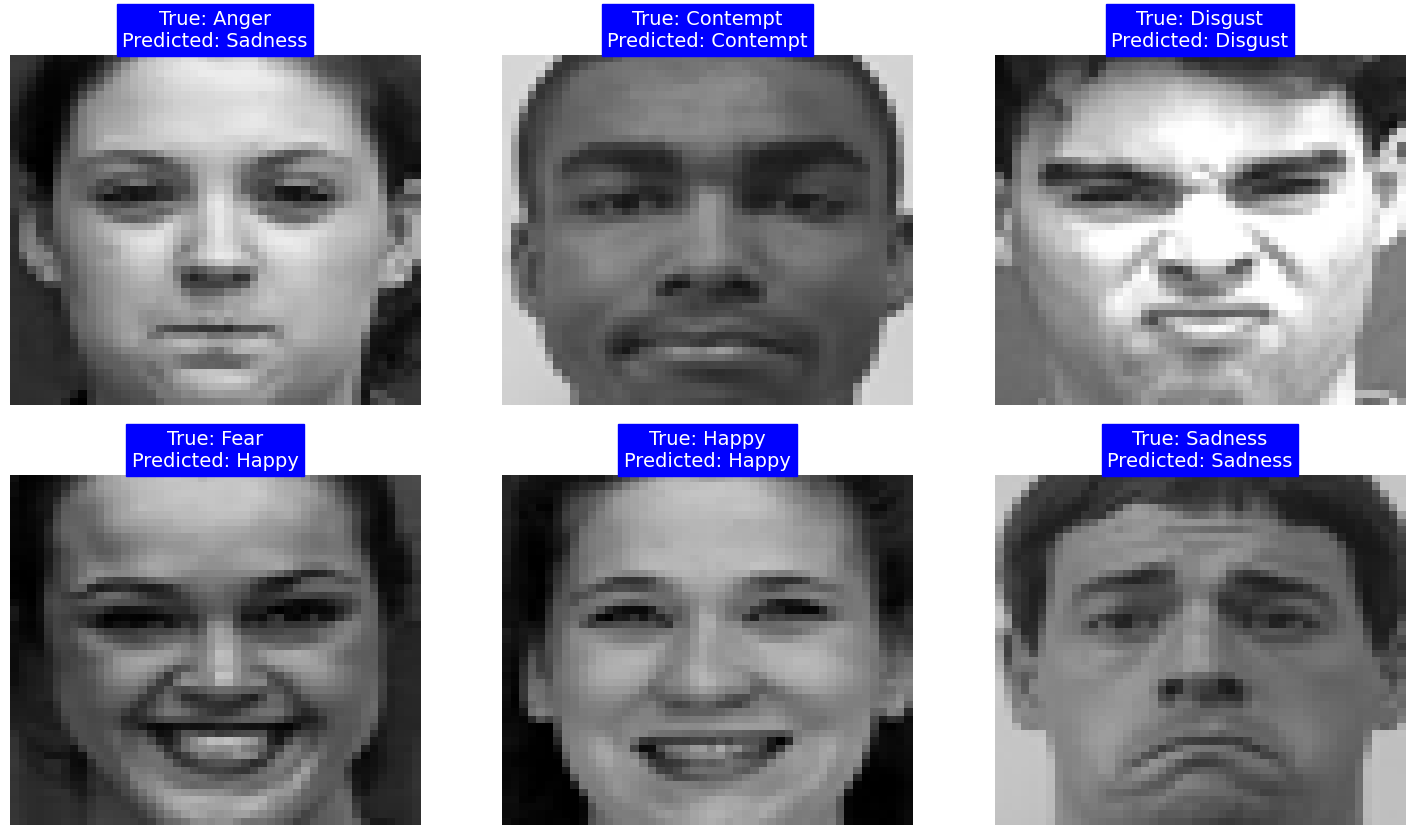

In [185]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_test contains your images and y_test contains true labels
label_names = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Sadness', 'Surprise']

# Get model predictions for the test set
y_pred_probs = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Initialize a dictionary to keep track of the number of times each class has been visualized
class_count = {label: 0 for label in label_names}

# Define the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 3  # You can adjust this based on your preference

# Set up the subplot grid with larger figsize
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 10))

# Visualize one image per class (no more than two times)
for i, label in enumerate(label_names):
    # Find the indices of images with the current label
    class_indices = np.where(np.argmax(y_test, axis=1) == i)[0]

    # Take the first image if available, otherwise take the second image
    if class_count[label] < len(class_indices):
        idx = class_indices[class_count[label]]
        img = X_test[idx]

        # Increase the size of the image
        axes[i // num_cols, i % num_cols].imshow(img, interpolation='nearest', aspect='auto')

        true_label = label_names[np.argmax(y_test[idx])]
        pred_label = label_names[y_pred_classes[idx]]

        # Customize labels with different colors
        title = f'True: {true_label}\nPredicted: {pred_label}'
        axes[i // num_cols, i % num_cols].set_title(title, fontsize=14, color='white', backgroundcolor='blue')

        axes[i // num_cols, i % num_cols].axis('off')  # Turn off axis ticks and labels

        # Increment the count for the current class
        class_count[label] += 1

plt.tight_layout()

# Save the figure with DPI 1200
plt.savefig('visualization_image.png', dpi=1200, bbox_inches='tight')

plt.show()


7/7 [==============================] - 0s 14ms/step


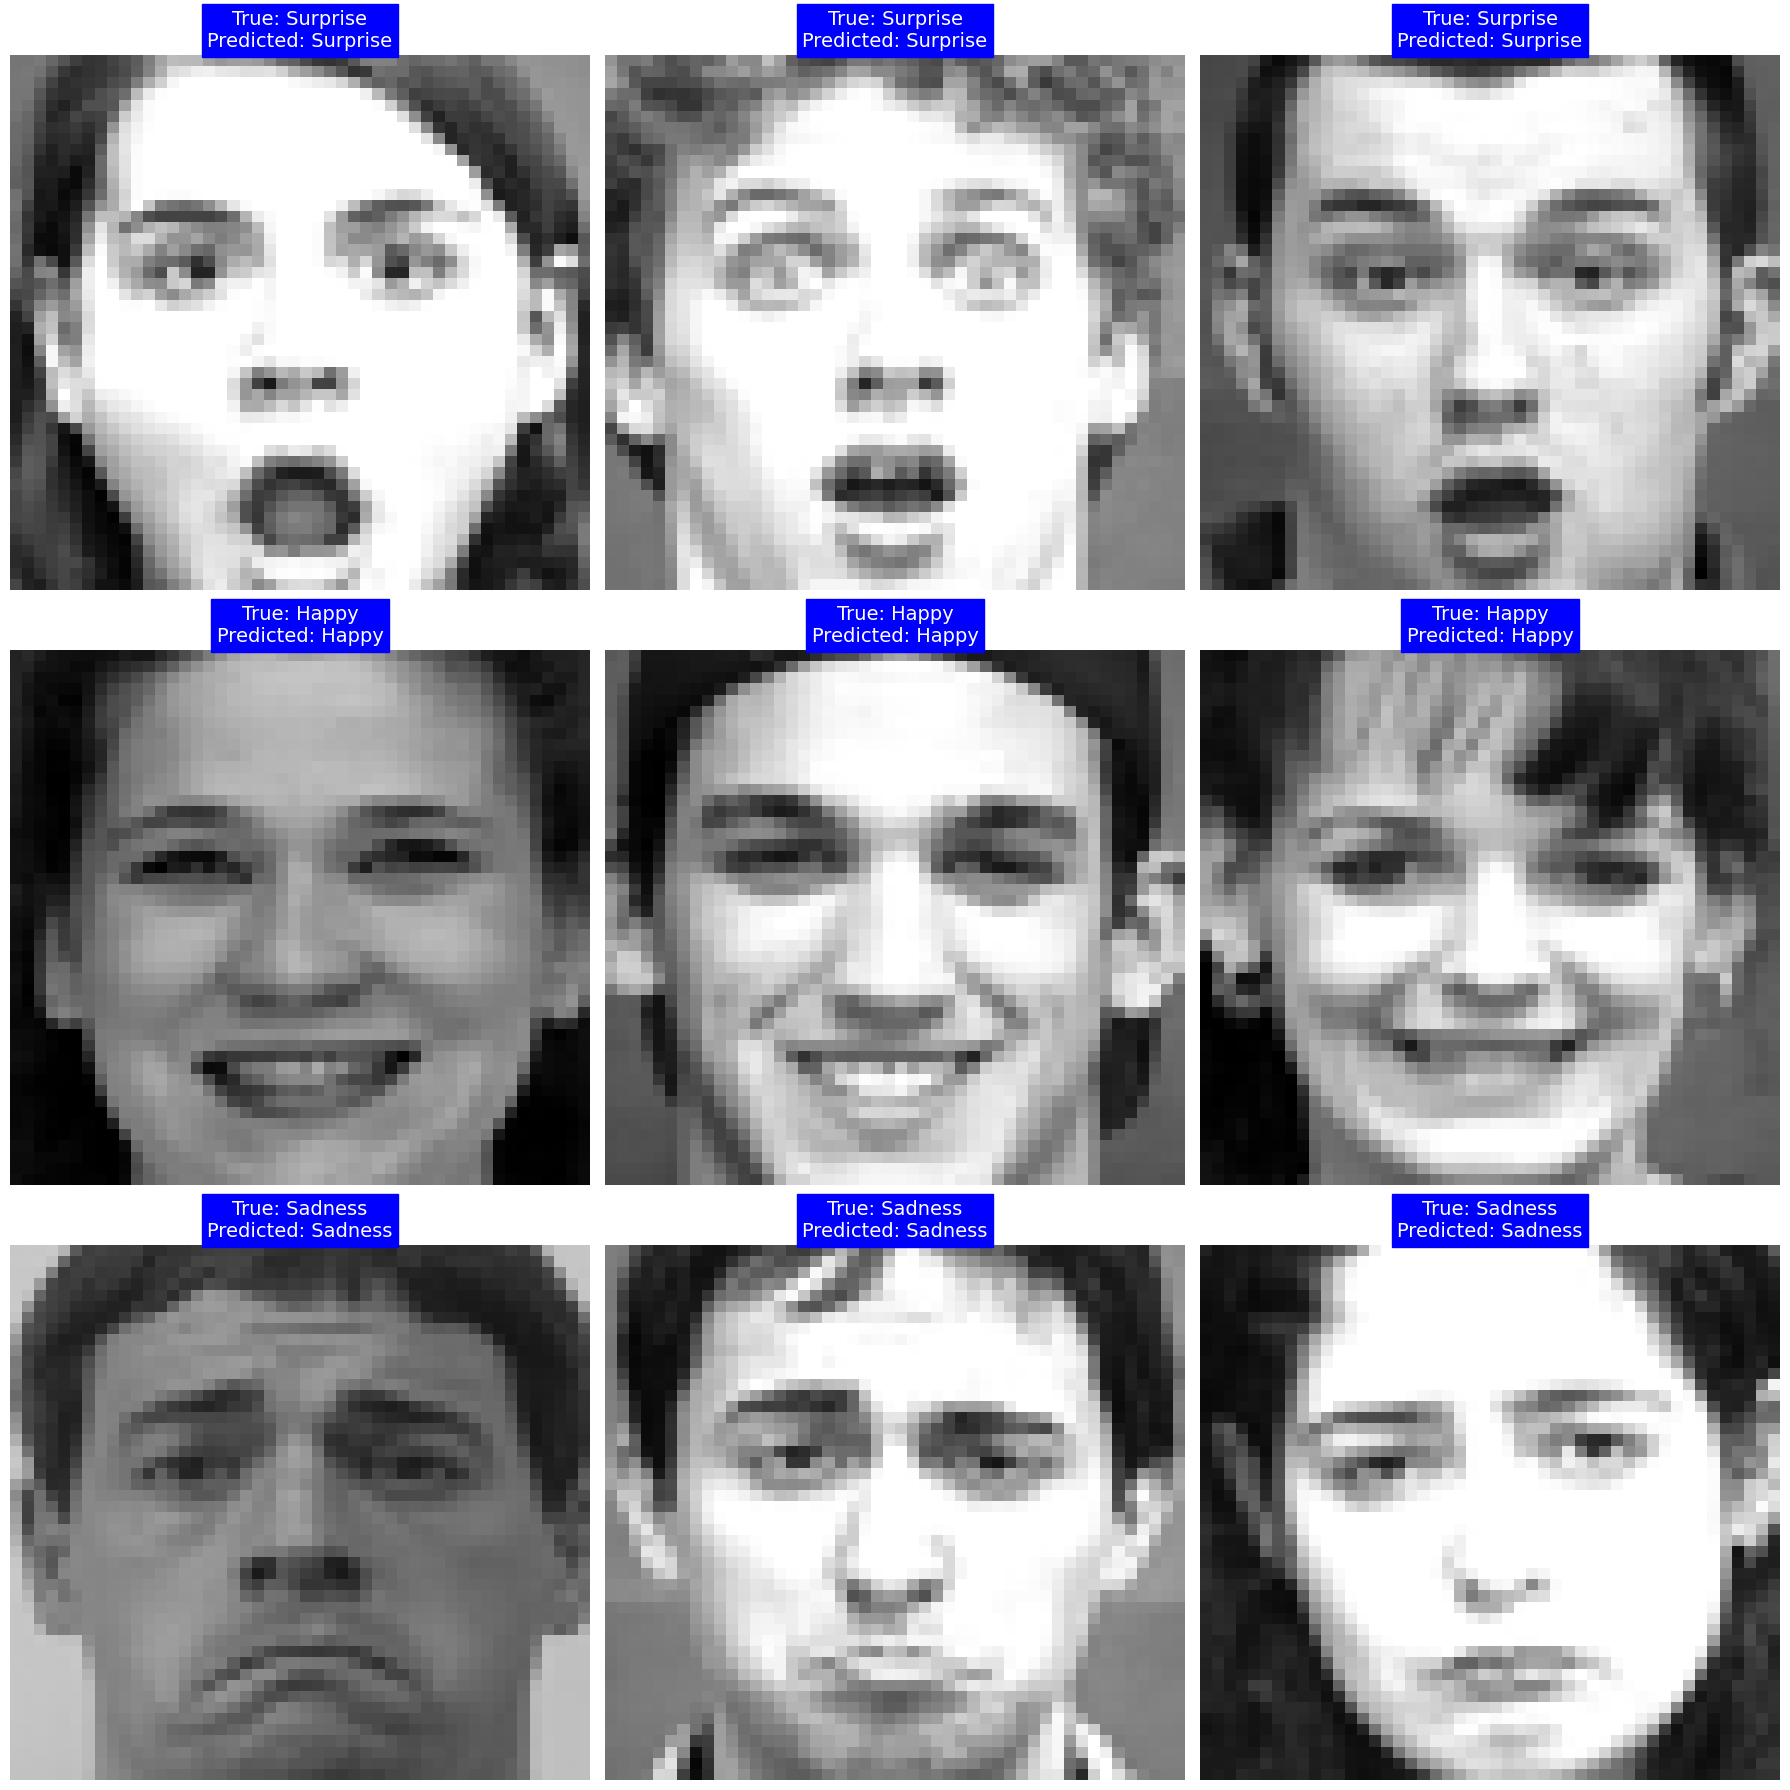

In [193]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_test contains your images and y_test contains true labels
label_names = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Sadness', 'Surprise']

# Get model predictions for the test set
y_pred_probs = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Initialize a dictionary to keep track of the number of times each class has been visualized
class_count = {label: 0 for label in label_names}

# Define the number of rows and columns for the subplot grid
num_rows = 3
num_cols = 3  # You can adjust this based on your preference

# Set up the subplot grid with larger figsize
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 18))

# Visualize the same three images in columns and three in rows
for i, label in enumerate(label_names):
    # Find the indices of images with the current label
    class_indices = np.where(np.argmax(y_test, axis=1) == i)[0]

    # Take the first three images if available
    for j in range(min(3, len(class_indices))):
        idx = class_indices[j]
        img = X_test[idx]

        # Increase the size of the image
        axes[i % num_rows, j].imshow(img, interpolation='nearest', aspect='auto')

        true_label = label_names[np.argmax(y_test[idx])]
        pred_label = label_names[y_pred_classes[idx]]

        # Customize labels with different colors
        title = f'True: {true_label}\nPredicted: {pred_label}'
        axes[i % num_rows, j].set_title(title, fontsize=14, color='white', backgroundcolor='blue')

        axes[i % num_rows, j].axis('off')  # Turn off axis ticks and labels

plt.tight_layout()

# Save the figure with DPI 1200
plt.savefig('visualization_image.png', dpi=1200, bbox_inches='tight')

plt.show()


# For live test

In [198]:
from keras.models import load_model
from time import sleep
from tensorflow.keras.preprocessing.image import img_to_array
from keras.preprocessing import image
import cv2
import numpy as np

face_classifier=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
emotion_model = load_model('best_weights_best_4.hdf5')


class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']


cap=cv2.VideoCapture(0)

while True:
    ret,frame=cap.read()
    labels=[]
    
    gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces=face_classifier.detectMultiScale(gray,1.3,2)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation=cv2.INTER_AREA)

        # Convert grayscale image to RGB
        roi = cv2.cvtColor(roi_gray, cv2.COLOR_GRAY2RGB)

        # Get image ready for prediction
        roi = roi.astype('float') / 255.0  # Scale
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)  # Expand dims to get it ready for prediction (1, 48, 48, 3)

        preds = emotion_model.predict(roi)[0]  # Yields one hot encoded result for 7 classes
        label = class_labels[preds.argmax()]  # Find the label
        label_position = (x, y)
        cv2.putText(frame, label, label_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Emotion Detector', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


# MOdified CNN model:

In [227]:
from tensorflow.keras.layers import Attention
import keras